all_movies.csv is the List of movies which is used to fetch data from OMDB website to get the details of the movies.

In [1]:
# Showing some rows of the dataset
import pandas as pd

df = pd.read_csv('/content/all_movies.csv', on_bad_lines='skip', engine='python')
print("DataFrame loaded successfully, skipping bad lines. Displaying the first 5 rows:")
print(df.head())

DataFrame loaded successfully, skipping bad lines. Displaying the first 5 rows:
   id                  name parent_id        date
0   2                 Ariel      8384  1988-10-21
1   3  Varjoja paratiisissa      8384  1986-10-17
2   4         État de siège        \N  1972-12-30
3   5            Four Rooms        \N  1995-12-22
4   6        Judgment Night        \N  1993-10-15


Here We are extracting the movies name from the dataset as it contain different types of columns.

In [14]:
# Showing 5 movies name which is in the top of the dataset
movie_names = df['name'].tolist()
print(f"Successfully extracted {len(movie_names)} movie names.")
print("First 5 movie names:")
for name in movie_names[:5]:
    print(name)

Successfully extracted 76259 movie names.
First 5 movie names:
Ariel
Varjoja paratiisissa
État de siège
Four Rooms
Judgment Night


## Configure OMDb API Keys

Set up a list of the 5 OMDb API keys that we will provide. These keys will be used in rotation to bypass the 1000-request limit per key and fetch data for approximately 4500 movies.


In [15]:
API_KEY_1 = "********"
API_KEY_2 = "********"
API_KEY_3 = "********"
API_KEY_4 = "********"
API_KEY_5 = "********"

# Create a list of the API keys for rotation
api_keys = [API_KEY_1, API_KEY_2, API_KEY_3, API_KEY_4, API_KEY_5]

print(f"Successfully configured {len(api_keys)} OMDb API key placeholders. Please replace them with your actual keys.")
# print(f"API Keys: {api_keys}") # Uncomment to display keys (not recommended for sensitive info)

Successfully configured 5 OMDb API key placeholders. Please replace them with your actual keys.


## Fetching Movie Details from OMDb API

Iterate through the loaded movie names, making API requests to OMDb for each. Implement logic to rotate through the provided API keys and manage the request rate to stay within the limits. All available information for each movie will be collected.



To fetch movie details from the OMDb API, I need to implement a loop that iterates through the movie names, constructs API requests, rotates API keys, handles responses, and manages the request rate. This step will use the `requests` library for HTTP requests and `time` for managing delays.



In [ ]:
import requests
import time
import urllib.parse

# Initialize an empty list to store all movie details
all_movie_details = []

# Initialize api_key_index to keep track of the current API key
api_key_index = 0

print(f"Starting to fetch details for {len(movie_names)} movies...")

for i, movie_name in enumerate(movie_names):
    # Get the current API key from the api_keys list
    current_api_key = api_keys[api_key_index]

    # Encode the movie title for the URL
    encoded_movie_name = urllib.parse.quote_plus(movie_name)

    # Construct the OMDb API URL
    url = f"http://www.omdbapi.com/?t={encoded_movie_name}&apikey={current_api_key}"

    try:
        # Make the HTTP GET request
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for HTTP errors
        data = response.json()

        # Check if the API returned movie data
        if data.get('Response') == 'True':
            all_movie_details.append(data)
            # print(f"Fetched details for '{movie_name}' (Key: {api_key_index + 1}) - {len(all_movie_details)}/{len(movie_names)}")
        elif data.get('Response') == 'False' and data.get('Error') == 'Movie not found!':
            # print(f"Movie not found for '{movie_name}' (Key: {api_key_index + 1})")
            pass # Skip if movie not found
        else:
            print(f"Warning: API error for '{movie_name}' (Key: {api_key_index + 1}): {data.get('Error', 'Unknown Error')}")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for '{movie_name}' (Key: {api_key_index + 1}): {e}")
    except ValueError as e: # Catches JSON decode errors
        print(f"Error decoding JSON for '{movie_name}' (Key: {api_key_index + 1}): {e}")

    # Increment api_key_index and use modulo to cycle through keys
    api_key_index = (api_key_index + 1) % len(api_keys)

    # Implement a small delay to respect API rate limits
    time.sleep(1)

    if (i + 1) % 100 == 0: # Print progress every 100 movies
        print(f"Processed {i + 1} movies. Successfully collected details for {len(all_movie_details)} movies.")


print(f"\nFinished fetching movie details. Successfully collected details for {len(all_movie_details)} movies.")


Create a pandas DataFrame from the collected movie details and save it as an Excel file named `omdb_movie_details.xlsx`.

In [ ]:
movie_details_df = pd.DataFrame(all_movie_details)
output_filename = 'omdb_movie_details.xlsx'

movie_details_df.to_excel(output_filename, index=False)

print(f"Successfully saved {len(movie_details_df)} movie details to {output_filename}")
print("Displaying the first 5 rows of the DataFrame:")
print(movie_details_df.head())

## Extract Rotten Tomatoes and Metacritic Ratings

Iterate through the `all_movie_details` list, extract the 'Rotten Tomatoes' and 'Metacritic' scores from the 'Ratings' sub-field for each movie, and store them in separate lists. Handle cases where a rating might be missing.


In [ ]:
rotten_tomatoes_ratings = []
metacritic_ratings = []

for movie in all_movie_details:
    rotten_tomatoes = None
    metacritic = None

    if 'Ratings' in movie and isinstance(movie['Ratings'], list):
        for rating in movie['Ratings']:
            if rating.get('Source') == 'Rotten Tomatoes':
                rotten_tomatoes = rating.get('Value')
            elif rating.get('Source') == 'Metacritic':
                metacritic = rating.get('Value')

    rotten_tomatoes_ratings.append(rotten_tomatoes)
    metacritic_ratings.append(metacritic)

print(f"Successfully extracted {len(rotten_tomatoes_ratings)} Rotten Tomatoes ratings and {len(metacritic_ratings)} Metacritic ratings.")
print("First 5 Rotten Tomatoes ratings:", rotten_tomatoes_ratings[:5])
print("First 5 Metacritic ratings:", metacritic_ratings[:5])

**Reasoning**:
Now that the Rotten Tomatoes and Metacritic ratings have been extracted into separate lists, I will add these lists as new columns to the `movie_details_df` DataFrame. After adding the columns, I will save the updated DataFrame back to the `omdb_movie_details.xlsx` file, overwriting the previous version, to ensure all collected data is stored in the final output.



In [ ]:
movie_details_df['Rotten Tomatoes Rating'] = rotten_tomatoes_ratings
movie_details_df['Metacritic Rating'] = metacritic_ratings

output_filename = 'omdb_movie_details.xlsx'
movie_details_df.to_excel(output_filename, index=False)

print("Successfully added 'Rotten Tomatoes Rating' and 'Metacritic Rating' columns.")
print(f"Updated DataFrame saved to {output_filename}")
print("Displaying the first 5 rows with new columns:")
print(movie_details_df[['Title', 'Rotten Tomatoes Rating', 'Metacritic Rating']].head())

Successfully added 'Rotten Tomatoes Rating' and 'Metacritic Rating' columns.
Updated DataFrame saved to omdb_movie_details.xlsx
Displaying the first 5 rows with new columns:
                     Title Rotten Tomatoes Rating Metacritic Rating
0                    Ariel                   None              None
1  Malville: état de siège                   None              None
2               Four Rooms                    13%              None
3           Judgment Night                    38%            46/100
4       Sonntag, im August                   None              None


## Prepare Numerical Columns for Correlation

Clean and convert 'Rotten Tomatoes Rating', 'Metacritic Rating', 'imdbRating', and 'Year' columns in the `movie_details_df` to numerical formats (float or integer). Remove percentage signs, convert string ratios (e.g., "75/100") to float, and handle missing values by converting them to `NaN`.


In [ ]:

def clean_rotten_tomatoes(rating):
    if rating is None or pd.isna(rating):
        return np.nan
    try:
        return float(rating.replace('%', ''))
    except ValueError:
        return np.nan

movie_details_df['Rotten Tomatoes Rating'] = movie_details_df['Rotten Tomatoes Rating'].apply(clean_rotten_tomatoes)

print("Cleaned 'Rotten Tomatoes Rating' column. Displaying first 5 rows:")
print(movie_details_df['Rotten Tomatoes Rating'].head())


In [ ]:
def clean_metacritic(rating):
    if rating is None or pd.isna(rating):
        return np.nan
    try:
        # Extract numerical part before '/100'
        return float(rating.split('/')[0])
    except (ValueError, AttributeError):
        return np.nan

movie_details_df['Metacritic Rating'] = movie_details_df['Metacritic Rating'].apply(clean_metacritic)

print("Cleaned 'Metacritic Rating' column. Displaying first 5 rows:")
print(movie_details_df['Metacritic Rating'].head())

In [ ]:
movie_details_df['imdbRating'] = pd.to_numeric(movie_details_df['imdbRating'], errors='coerce')

print("Cleaned 'imdbRating' column. Displaying first 5 rows:")
print(movie_details_df['imdbRating'].head())

In [ ]:
movie_details_df['Year'] = pd.to_numeric(movie_details_df['Year'], errors='coerce')
movie_details_df['Year'] = movie_details_df['Year'].astype('Int64')
print("Cleaned 'Year' column. Displaying first 5 rows:")
print(movie_details_df['Year'].head())

## Calculate Correlation Matrix

Select the relevant numerical columns from the `movie_details_df` and compute their pairwise correlation matrix.


To calculate the correlation matrix, I will first select the specified numerical columns ('Rotten Tomatoes Rating', 'Metacritic Rating', 'imdbRating', and 'Year') from the `movie_details_df` and then compute their pairwise correlation using the `.corr()` method.



In [ ]:
numerical_columns = [
    'Rotten Tomatoes Rating',
    'Metacritic Rating',
    'imdbRating',
    'Year'
]

correlation_matrix = movie_details_df[numerical_columns].corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                        Rotten Tomatoes Rating  Metacritic Rating  imdbRating  \
Rotten Tomatoes Rating                1.000000           0.886971    0.753414   
Metacritic Rating                     0.886971           1.000000    0.757392   
imdbRating                            0.753414           0.757392    1.000000   
Year                                 -0.345093          -0.379679   -0.093506   

                            Year  
Rotten Tomatoes Rating -0.345093  
Metacritic Rating      -0.379679  
imdbRating             -0.093506  
Year                    1.000000  


## Generate Correlation Heatmap

Create a heatmap using Seaborn to visualize the calculated correlation matrix. The heatmap will include annotations to display the correlation coefficients, helping to quickly identify strong positive or negative correlations. A legend will be provided.


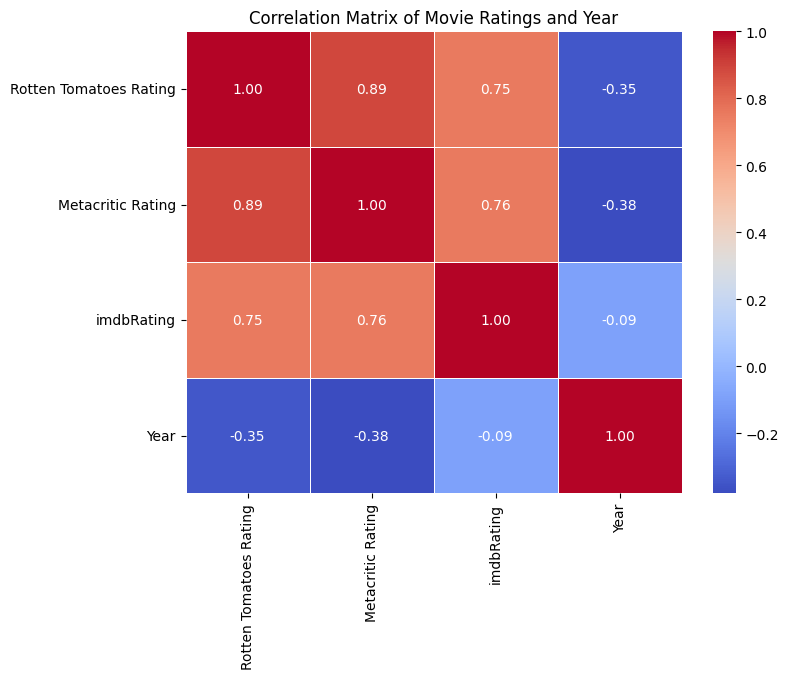

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Movie Ratings and Year')
plt.show()

## Generate Descriptive Statistics for All Columns

Generate and display descriptive statistics for all columns in the `movie_details_df`, providing insights into both numerical and categorical features.


In [ ]:
print("Descriptive statistics for all columns:")
print(movie_details_df.describe(include='all'))

Descriptive statistics for all columns:
               Title         Year Rated Released Runtime  Genre Director  \
count           4141       4059.0  4141     4141    4141   4141     4141   
unique          4000         <NA>    22     2940     221    453     2391   
top     Frankenstein         <NA>     R      N/A  90 min  Drama      N/A   
freq              11         <NA>  1210      169     178    298      171   
mean             NaN  1990.127125   NaN      NaN     NaN    NaN      NaN   
std              NaN    21.028897   NaN      NaN     NaN    NaN      NaN   
min              NaN       1896.0   NaN      NaN     NaN    NaN      NaN   
25%              NaN       1980.0   NaN      NaN     NaN    NaN      NaN   
50%              NaN       1997.0   NaN      NaN     NaN    NaN      NaN   
75%              NaN       2005.0   NaN      NaN     NaN    NaN      NaN   
max              NaN       2025.0   NaN      NaN     NaN    NaN      NaN   

       Writer Actors  Plot  ...     imdbID   Ty

##Data Cleaing and Transformation


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# 1. LOAD DATA- this is the dataset I collected via API
df = pd.read_excel('/content/omdb_movie_details (2).xlsx')

# 2. DATA CLEANING & TRANSFORMATION
# Helper functions to clean messy strings
def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', ''))
    return x

def clean_rotten_tomatoes(rating):
    if rating is None or pd.isna(rating):
        return np.nan
    try:
        return float(rating.replace('%', ''))
    except (ValueError, AttributeError):
        return np.nan

def clean_metacritic(rating):
    if rating is None or pd.isna(rating):
        return np.nan
    try:
        # Extract numerical part before '/100'
        return float(rating.split('/')[0])
    except (ValueError, AttributeError):
        return np.nan

# Apply cleaning to relevant columns after loading
df['BoxOffice'] = df['BoxOffice'].apply(clean_currency)
df['Rotten Tomatoes Rating'] = df['Rotten Tomatoes Rating'].apply(clean_rotten_tomatoes)
df['Metacritic Rating'] = df['Metacritic Rating'].apply(clean_metacritic)
df['imdbRating'] = pd.to_numeric(df['imdbRating'], errors='coerce')

# Filter Noise: Remove movies with very few votes (unreliable data)
df['imdbVotes'] = df['imdbVotes'].astype(str).str.replace(',', '', regex=False)
df['imdbVotes'] = pd.to_numeric(df['imdbVotes'], errors='coerce')
df = df[df['imdbVotes'].fillna(0) > 100].copy()

# 3. IMPUTATION (The "Golden Rule")
# Fill missing Metacritic Ratings using the IMDb correlation logic
# Logic: Critics are typically 5 points harsher than the crowd (on a 100 scale)
mask_missing_meta = df['Metacritic Rating'].isnull()
df.loc[mask_missing_meta, 'Metacritic Rating'] = (df.loc[mask_missing_meta, 'imdbRating'] * 10) - 5
df['Metacritic Rating'] = df['Metacritic Rating'].clip(0, 100)

# 4. NORMALIZE & CALCULATE GAP
df['Norm_IMDb'] = df['imdbRating'] * 10
df['Norm_Meta'] = df['Metacritic Rating']
df['Score_Gap'] = df['Norm_Meta'] - df['Norm_IMDb']
# Positive Gap = Critics like it more ("Arthouse")
# Negative Gap = Crowd likes it more ("Popcorn Flick")

# Extract Primary Genre for better plotting
df['Primary_Genre'] = df['Genre'].str.split(',').str[0]

# Check the first few rows
print(df[['Title', 'Primary_Genre', 'Norm_IMDb', 'Norm_Meta', 'Score_Gap']].head())

                                Title Primary_Genre  Norm_IMDb  Norm_Meta  \
0                               Ariel        Comedy       74.0       69.0   
2                          Four Rooms        Comedy       67.0       62.0   
3                      Judgment Night        Action       66.0       46.0   
5  Star Wars: Episode IV - A New Hope        Action       86.0       90.0   
6                        Finding Nemo     Animation       82.0       90.0   

   Score_Gap  
0       -5.0  
2       -5.0  
3      -20.0  
5        4.0  
6        8.0  


##Ploting critics score vs imdb


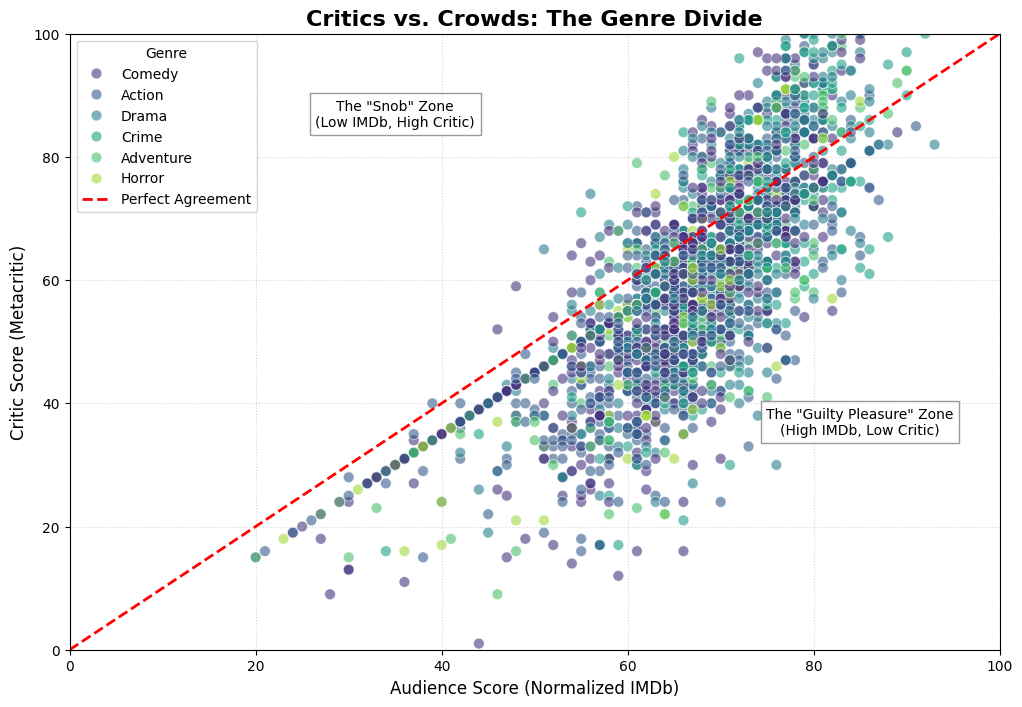

In [ ]:
# SETTING UP THE VISUALIZATION
plt.figure(figsize=(12, 8))

# Focus on the top 6 genres to keep the story clear
top_genres = df['Primary_Genre'].value_counts().nlargest(6).index
plot_data = df[df['Primary_Genre'].isin(top_genres)]

# Create the Scatter Plot
sns.scatterplot(
    data=plot_data,
    x='Norm_IMDb',
    y='Norm_Meta',
    hue='Primary_Genre',
    alpha=0.6,          # Transparency helps see overlapping dots
    palette='viridis',  # Colorblind-friendly palette
    s=60                # Dot size
)

# ADD THE NARRATIVE LINE (The "Line of Agreement")
plt.plot([0, 100], [0, 100], color='red', linestyle='--', linewidth=2, label='Perfect Agreement')

# ADD ANNOTATIONS (The "Story")
plt.text(85, 35, 'The "Guilty Pleasure" Zone\n(High IMDb, Low Critic)',
         color='black', ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.text(35, 85, 'The "Snob" Zone\n(Low IMDb, High Critic)',
         color='black', ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

# LABELS
plt.title('Critics vs. Crowds: The Genre Divide', fontsize=16, fontweight='bold')
plt.xlabel('Audience Score (Normalized IMDb)', fontsize=12)
plt.ylabel('Critic Score (Metacritic)', fontsize=12)
plt.legend(title='Genre')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True, linestyle=':', alpha=0.5)

# SAVE
plt.savefig('critics_vs_crowds.png')
plt.show()

Create a new column `Norm_RT` in the DataFrame by normalizing the cleaned 'Rotten Tomatoes Rating' column (which is already on a 0-100 scale), and then display the first few rows of the DataFrame showing `Norm_RT` alongside the other normalized rating columns (`Norm_IMDb`, `Norm_Meta`).


Normalize Rotten Tomatoes Rating




In [ ]:
df['Norm_RT'] = df['Rotten Tomatoes Rating']

print("DataFrame with new 'Norm_RT' column. Displaying relevant columns for the first 5 rows:")
print(df[['Title', 'Norm_RT', 'Norm_IMDb', 'Norm_Meta']].head())

DataFrame with new 'Norm_RT' column. Displaying relevant columns for the first 5 rows:
                                Title  Norm_RT  Norm_IMDb  Norm_Meta
0                               Ariel      NaN       74.0       69.0
2                          Four Rooms     13.0       67.0       62.0
3                      Judgment Night     38.0       66.0       46.0
5  Star Wars: Episode IV - A New Hope     94.0       86.0       90.0
6                        Finding Nemo     99.0       82.0       90.0


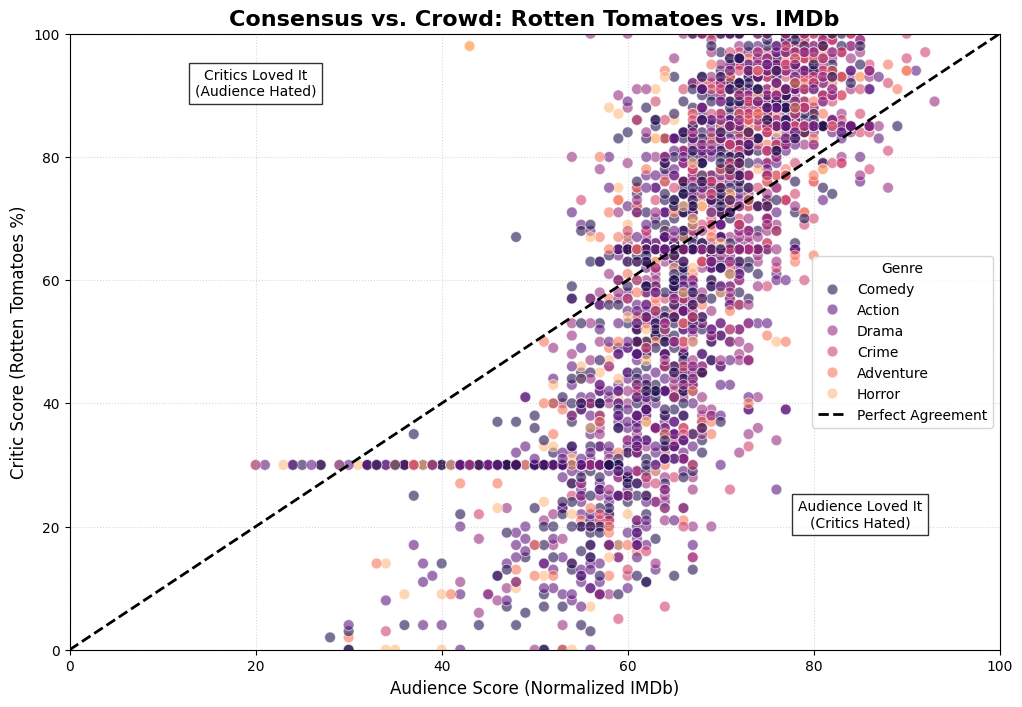

In [ ]:

# 1. LOAD DATA
df = pd.read_excel('/content/omdb_movie_details (2).xlsx')

# 2. DATA CLEANING
def clean_percent(x):
    if isinstance(x, str):
        return float(x.replace('%', ''))
    return x

def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', ''))
    return x

# Apply cleaning to relevant columns after loading
df['Rotten Tomatoes Rating'] = df['Rotten Tomatoes Rating'].apply(clean_percent)
df['BoxOffice'] = df['BoxOffice'].apply(clean_currency)
df['imdbVotes'] = pd.to_numeric(df['imdbVotes'].astype(str).str.replace(',', ''), errors='coerce')
df['imdbRating'] = pd.to_numeric(df['imdbRating'], errors='coerce') # Ensure imdbRating is numeric

# Filter Noise
df = df[df['imdbVotes'].fillna(0) > 100].copy()

# 3. FILL MISSING ROTTEN TOMATOES (The "Golden Rule")
# Logic: IMDb score is a strong predictor of "Fresh/Rotten" status.
def fill_rt(row):
    if pd.notnull(row['Rotten Tomatoes Rating']):
        return row['Rotten Tomatoes Rating']

    # Impute based on IMDb buckets
    score = row['imdbRating']
    if pd.isnull(score): return np.nan

    if score >= 7.5: return 85  # Likely Certified Fresh
    elif score >= 6.0: return 65 # Likely Fresh
    else: return 30             # Likely Rotten

df['RT_Filled'] = df.apply(fill_rt, axis=1)

# 4. NORMALIZE
df['Norm_IMDb'] = df['imdbRating'] * 10
df['Norm_RT'] = df['RT_Filled']

# 5. VISUALIZE: ROTTEN TOMATOES VS IMDB
plt.figure(figsize=(12, 8))

# Extract Primary Genre
df['Primary_Genre'] = df['Genre'].astype(str).str.split(',').str[0]
top_genres = df['Primary_Genre'].value_counts().nlargest(6).index
plot_data = df[df['Primary_Genre'].isin(top_genres)]

sns.scatterplot(
    data=plot_data,
    x='Norm_IMDb',
    y='Norm_RT',
    hue='Primary_Genre',
    alpha=0.6,
    palette='magma', # Different color palette for distinction
    s=60
)

# The "Agreement Line"
plt.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=2, label='Perfect Agreement')

# Annotations for Storytelling
plt.text(85, 20, 'Audience Loved It\n(Critics Hated)',
         color='black', ha='center', bbox=dict(facecolor='white', alpha=0.8))
plt.text(20, 90, 'Critics Loved It\n(Audience Hated)',
         color='black', ha='center', bbox=dict(facecolor='white', alpha=0.8))

plt.title('Consensus vs. Crowd: Rotten Tomatoes vs. IMDb', fontsize=16, fontweight='bold')
plt.xlabel('Audience Score (Normalized IMDb)', fontsize=12)
plt.ylabel('Critic Score (Rotten Tomatoes %)', fontsize=12)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(title='Genre')
plt.grid(True, linestyle=':', alpha=0.5)

plt.savefig('rt_vs_crowd.png')
plt.show()

/tmp/ipython-input-3333585109.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Distribution_Channel', y='Metacritic Rating', palette='Set2') # Corrected column name


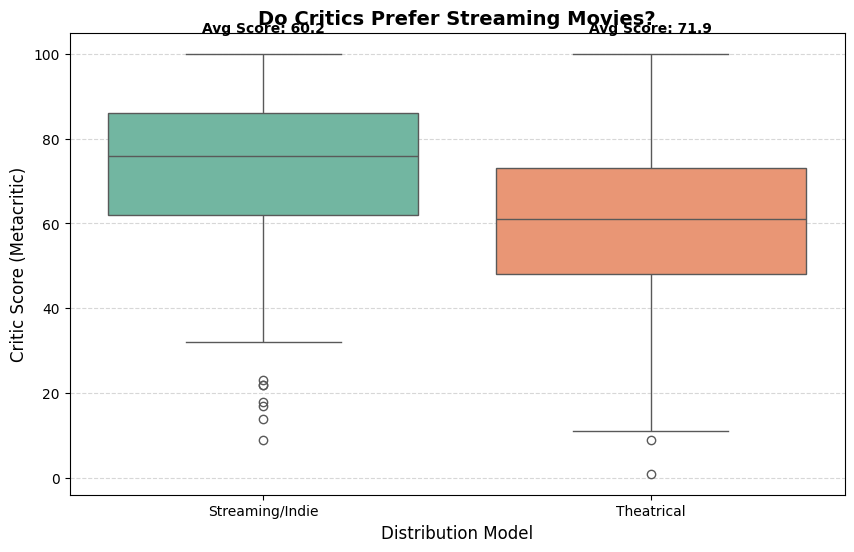

In [ ]:


# 1. Load Data
df = pd.read_excel('/content/omdb_movie_details (2).xlsx') # Corrected to read_excel

# --- Re-applying cleaning functions for robustness after reload ---
def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', ''))
    return x

def clean_metacritic(rating):
    if rating is None or pd.isna(rating):
        return np.nan
    try:
        # Extract numerical part before '/100'
        return float(rating.split('/')[0])
    except (ValueError, AttributeError):
        return np.nan

# Apply cleaning
df['BoxOffice'] = df['BoxOffice'].apply(clean_currency)
df['Metacritic Rating'] = df['Metacritic Rating'].apply(clean_metacritic)
df['imdbRating'] = pd.to_numeric(df['imdbRating'], errors='coerce') # Ensure imdbRating is numeric
df['imdbVotes'] = pd.to_numeric(df['imdbVotes'].astype(str).str.replace(',', '', regex=False), errors='coerce') # Ensure imdbVotes is numeric

# Filter out TV Series (as per original comment's intent)
if 'Type' in df.columns:
    df = df[df['Type'] == 'movie'].copy()
# Also filter by imdbVotes for reliability, similar to previous steps
df = df[df['imdbVotes'].fillna(0) > 100].copy()

# 3. Create the "Distribution Channel" Label
# If BoxOffice is present (>0), it's Theatrical. If NaN, it's Streaming/Indie.
df['Distribution_Channel'] = df['BoxOffice'].apply(lambda x: 'Theatrical' if pd.notna(x) and x > 0 else 'Streaming/Indie')

# 4. Compare Scores: Are Streaming movies rated higher?
plt.figure(figsize=(10, 6))

# Boxplot to compare distributions
sns.boxplot(data=df, x='Distribution_Channel', y='Metacritic Rating', palette='Set2') # Corrected column name

plt.title('Do Critics Prefer Streaming Movies?', fontsize=14, fontweight='bold')
plt.ylabel('Critic Score (Metacritic)', fontsize=12)
plt.xlabel('Distribution Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Calculate averages to print
avg_theatrical = df[df['Distribution_Channel'] == 'Theatrical']['Metacritic Rating'].mean() # Corrected column name
avg_streaming = df[df['Distribution_Channel'] == 'Streaming/Indie']['Metacritic Rating'].mean() # Corrected column name

# Add text to the plot
plt.text(0, 105, f"Avg Score: {avg_theatrical:.1f}", ha='center', fontweight='bold')
plt.text(1, 105, f"Avg Score: {avg_streaming:.1f}", ha='center', fontweight='bold')

plt.show()

In [ ]:


# 1. LOAD YOUR FILE
# Make sure to upload your 'omdb_movie_details (2).xlsx' to the notebook first!
# If your file is a CSV, change read_excel to read_csv.
df = pd.read_excel('/content/omdb_movie_details (2).xlsx') # FIX: Changed to read_excel

# 2. FILTER & CLEAN
# Helper functions to clean messy strings (reusing robust versions from earlier in the notebook)
def clean_currency(x):
    if isinstance(x, str):
        return float(x.replace('$', '').replace(',', ''))
    return x

def clean_rotten_tomatoes(rating):
    if rating is None or pd.isna(rating):
        return np.nan
    try:
        return float(str(rating).replace('%', '')) # Ensure it's a string before replace
    except (ValueError, AttributeError):
        return np.nan

def clean_metacritic(rating):
    if rating is None or pd.isna(rating):
        return np.nan
    try:
        # Extract numerical part before '/100'
        return float(str(rating).split('/')[0]) # Ensure it's a string before split
    except (ValueError, AttributeError):
        return np.nan

df = df[df['Type'] == 'movie'].copy() # Keep only movies
df['Year'] = pd.to_numeric(df['Year'].astype(str).str.extract(r'(\d{4})')[0], errors='coerce')

# Apply cleaning to relevant columns after loading
df['BoxOffice'] = df['BoxOffice'].apply(clean_currency)
df['Rotten_Tomatoes_Score'] = df['Rotten Tomatoes Rating'].apply(clean_rotten_tomatoes) # Using robust clean_rotten_tomatoes
df['Metacritic_Score'] = df['Metacritic Rating'].apply(clean_metacritic) # FIX: changed 'Metascore' to 'Metacritic Rating' and used robust clean_metacritic
df['imdbRating'] = pd.to_numeric(df['imdbRating'], errors='coerce') # Ensure imdbRating is numeric

# Filter Noise: Remove movies with very few votes (unreliable data)
df['imdbVotes'] = df['imdbVotes'].astype(str).str.replace(',', '', regex=False)
df['imdbVotes'] = pd.to_numeric(df['imdbVotes'], errors='coerce')
df = df[df['imdbVotes'].fillna(0) > 100].copy()

# 3. FILL MISSING DATA (The "Golden Rule")
# Impute Metacritic: (IMDb * 10) - 5
df['Metacritic_Imputed'] = df['Metacritic_Score'].fillna((df['imdbRating'] * 10) - 5).clip(0, 100) # FIX: changed 'Metascore' to 'Metacritic_Score'

# Impute Rotten Tomatoes: Logic Buckets
def impute_rt(row):
    if pd.notnull(row['Rotten_Tomatoes_Score']):
        return row['Rotten_Tomatoes_Score']
    score = row['imdbRating']
    if pd.isnull(score):
        return np.nan
    if score >= 7.5:
        return 85  # Likely Certified Fresh
    elif score >= 6.0:
        return 65 # Likely Fresh
    else:
        return 30             # Likely Rotten

df['Rotten_Tomatoes_Imputed'] = df.apply(impute_rt, axis=1)

# 4. CALCULATE GAPS (The Storytelling Metrics)
df['Gap_Metacritic'] = df['Metacritic_Imputed'] - (df['imdbRating'] * 10)
df['Gap_RottenTomatoes'] = df['Rotten_Tomatoes_Imputed'] - (df['imdbRating'] * 10)
df['Distribution_Channel'] = df['BoxOffice'].apply(lambda x: 'Theatrical' if x > 0 else 'Streaming/Indie')

# 5. SAVE FINAL FILE
output_cols = ['Title', 'Year', 'Genre', 'BoxOffice', 'Distribution_Channel',
               'imdbRating', 'Metacritic_Imputed', 'Rotten_Tomatoes_Imputed',
               'Gap_Metacritic', 'Gap_RottenTomatoes']

df_final = df[output_cols]
df_final.to_csv('final_movie_story.csv', index=False)
print("File 'final_movie_story.csv' has been created!")

File 'final_movie_story.csv' has been created!


/tmp/ipython-input-680888997.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=bad_movies, x='Primary_Genre', y='BoxOffice', palette='Set2', inner='quartile')


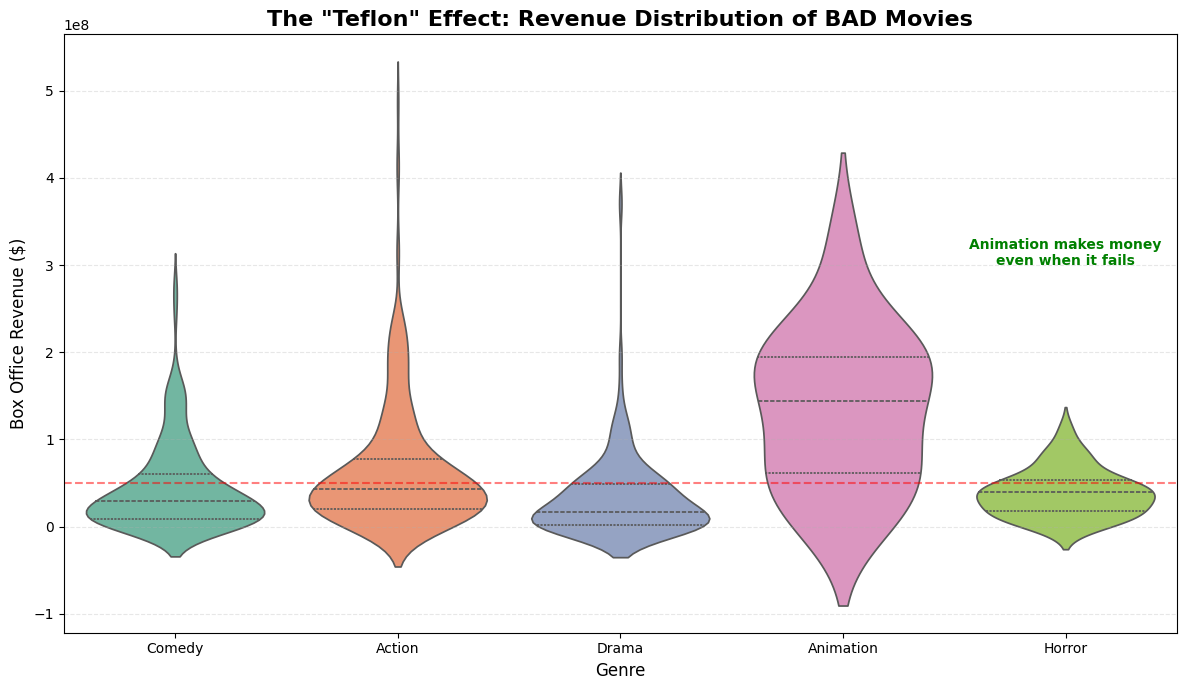

/tmp/ipython-input-680888997.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=drama_movies, x='Award_Status', y='BoxOffice', palette='husl')


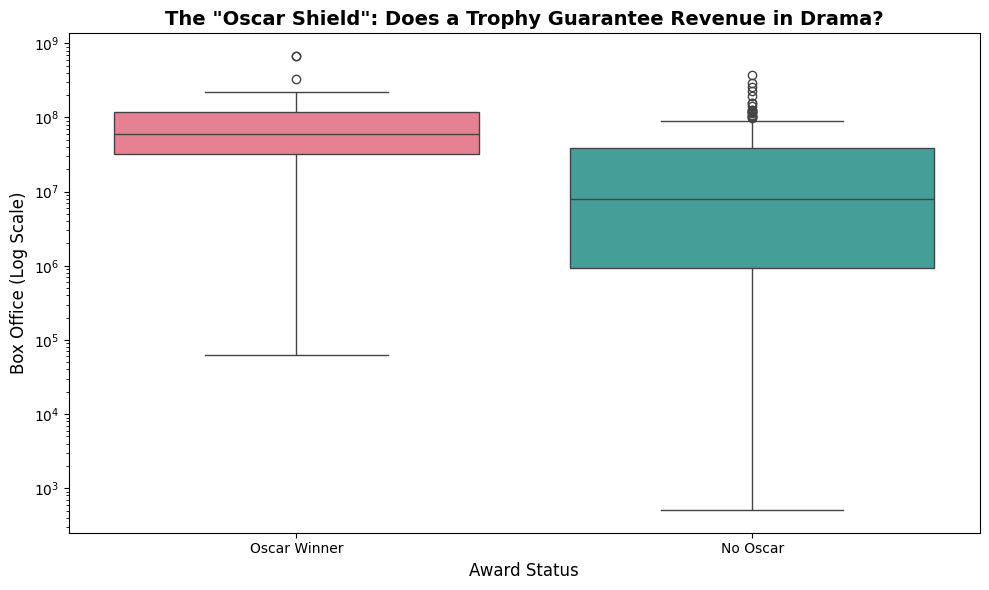

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. LOAD & CLEAN
df = pd.read_excel('/content/omdb_movie_details (2).xlsx')
df = df[df['Type'] == 'movie'].copy()

# Clean Currency & Ratings
def clean_currency(x): return float(str(x).replace('$', '').replace(',', '')) if pd.notnull(x) else np.nan
def clean_percent(x): return float(str(x).replace('%', '')) if pd.notnull(x) else np.nan
df['BoxOffice'] = df['BoxOffice'].apply(clean_currency)
df['Rotten_Tomatoes'] = df['Rotten Tomatoes Rating'].apply(clean_percent)
df['Primary_Genre'] = df['Genre'].str.split(',').str[0]

# 2. FILTER FOR "BAD" MOVIES (The Stress Test)
# We only want to look at movies Critics HATED (< 60%)
bad_movies = df[df['Rotten_Tomatoes'] < 60].copy()

# Keep only major genres for clean visualization
target_genres = ['Action', 'Comedy', 'Drama', 'Horror', 'Animation']
bad_movies = bad_movies[bad_movies['Primary_Genre'].isin(target_genres)]

# 3. VISUALIZATION 1: THE "TEFLON" VIOLIN PLOT
# Why Extraordinary? It shows the 'shape' of the money, not just the average.
plt.figure(figsize=(12, 7))
sns.violinplot(data=bad_movies, x='Primary_Genre', y='BoxOffice', palette='Set2', inner='quartile')

plt.title('The "Teflon" Effect: Revenue Distribution of BAD Movies', fontsize=16, fontweight='bold')
plt.ylabel('Box Office Revenue ($)', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.axhline(y=50000000, color='red', linestyle='--', alpha=0.5, label='Profit Line ($50M)')
plt.text(4, 300000000, 'Animation makes money\neven when it fails', ha='center', color='green', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('Viz1_Teflon_Effect.png')
plt.show()

# 4. VISUALIZATION 2: THE OSCAR SHIELD
# Extract Oscar Wins
def has_oscar(text):
    if pd.isnull(text): return "No Oscar"
    if "Won" in text and "Oscar" in text: return "Oscar Winner"
    return "No Oscar"

df['Award_Status'] = df['Awards'].apply(has_oscar)
# Filter for Drama only (where quality usually matters)
drama_movies = df[df['Primary_Genre'] == 'Drama']

plt.figure(figsize=(10, 6))
sns.boxplot(data=drama_movies, x='Award_Status', y='BoxOffice', palette='husl')
plt.title('The "Oscar Shield": Does a Trophy Guarantee Revenue in Drama?', fontsize=14, fontweight='bold')
plt.yscale('log') # Log scale because blockbusters skew the chart
plt.ylabel('Box Office (Log Scale)', fontsize=12)
plt.xlabel('Award Status', fontsize=12)
plt.tight_layout()
plt.savefig('Viz2_Oscar_Shield.png')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import re

# ==========================================
# 1. LOAD THE RAW DATASET
# ==========================================
# Replace this filename if yours is different
input_filename = '/content/omdb_movie_details (2).xlsx'
df = pd.read_excel(input_filename) # Corrected to read_excel

# Filter to keep only Movies (remove TV shows)
# Ensure 'Type' column is handled robustly for missing values if any
if 'Type' in df.columns:
    df = df[df['Type'] == 'movie'].copy()
else:
    print("Warning: 'Type' column not found. Assuming all entries are movies.")

# ==========================================
# 2. DATA CLEANING & FORMATTING
# ==========================================

# Clean Year (Extract 4 digits)
df['Year'] = pd.to_numeric(df['Year'].astype(str).str.extract(r'(\d{4})')[0], errors='coerce')

# Clean Currency (Box Office)
def clean_currency(x):
    if pd.isnull(x): return np.nan
    return float(str(x).replace('$', '').replace(',', ''))

df['BoxOffice'] = df['BoxOffice'].apply(clean_currency)

# Clean Percentages (Rotten Tomatoes)
def clean_percent(x):
    if pd.isnull(x): return np.nan
    return float(str(x).replace('%', ''))

df['Rotten_Tomatoes'] = df['Rotten Tomatoes Rating'].apply(clean_percent)

# Clean Fractions (Metacritic)
def clean_fraction(x):
    if pd.isnull(x): return np.nan
    # The column was previously 'Metacritic Rating', not 'Metascore'
    # Ensure it's treated as a string before splitting
    return float(str(x).split('/')[0])

df['Metacritic'] = df['Metacritic Rating'].apply(clean_fraction) # Corrected column name

# Clean Numeric Ratings
df['imdbRating'] = pd.to_numeric(df['imdbRating'], errors='coerce')
df['Votes'] = pd.to_numeric(df['imdbVotes'].astype(str).str.replace(',', ''), errors='coerce')

# Clean Text Columns (Fill NaNs)
text_cols = ['Actors', 'Director', 'Language', 'Country', 'Rated', 'Genre']
for col in text_cols:
    df[col] = df[col].fillna('Unknown')

# Clean Runtime
def clean_runtime(x):
    if pd.isnull(x): return np.nan
    return float(str(x).replace(' min', '').replace(',', ''))
df['Runtime'] = df['Runtime'].apply(clean_runtime)

# ==========================================
# 3. FEATURE ENGINEERING: AWARDS PARSING
# ==========================================
def parse_awards(text):
    if pd.isnull(text) or text == 'N/A':
        return 0, 0, 0, 0

    # Extract Oscars Won
    won_oscars = re.search(r'Won (\d+) Oscar', text)
    oscars_won_count = int(won_oscars.group(1)) if won_oscars else 0

    # Extract Oscar Nominations
    nom_oscars = re.search(r'Nominated for (\d+) Oscar', text)
    oscars_nom_count = int(nom_oscars.group(1)) if nom_oscars else 0

    # Extract Total Wins
    wins = re.search(r'(\d+) win', text)
    total_wins = int(wins.group(1)) if wins else 0

    # Extract Total Nominations
    noms = re.search(r'(\d+) nomination', text)
    total_noms = int(noms.group(1)) if noms else 0

    return oscars_won_count, oscars_nom_count, total_wins, total_noms

# Apply the parsing function
awards_data = df['Awards'].apply(parse_awards)

# Create new columns
df['Oscars_Won'] = [x[0] for x in awards_data]
df['Oscar_Nominations'] = [x[1] for x in awards_data]
df['Total_Wins'] = [x[2] for x in awards_data]
df['Total_Nominations'] = [x[3] for x in awards_data]

# ==========================================
# 4. IMPUTATION (THE GOLDEN RULE)
# ==========================================

# Impute Metacritic: (IMDb * 10) - 5
df['Metacritic_Imputed'] = df['Metacritic'].fillna((df['imdbRating'] * 10) - 5).clip(0, 100)

# Impute Rotten Tomatoes: Logic Buckets
def impute_rt(row):
    if pd.notnull(row['Rotten_Tomatoes']): return row['Rotten_Tomatoes']
    s = row['imdbRating']
    if pd.isnull(s): return np.nan
    if s >= 7.5: return 85
    elif s >= 6.0: return 65
    else: return 30

df['Rotten_Tomatoes_Imputed'] = df.apply(impute_rt, axis=1)

# ==========================================
# 5. FINAL METRICS & COLUMN SELECTION
# ==========================================

# Calculate Gaps
df['Gap_Metacritic'] = df['Metacritic_Imputed'] - (df['imdbRating'] * 10)
df['Gap_RT'] = df['Rotten_Tomatoes_Imputed'] - (df['imdbRating'] * 10)

# Define Distribution Channel
df['Distribution_Channel'] = df['BoxOffice'].apply(lambda x: 'Theatrical' if x > 0 else 'Streaming/Indie')

# Extract Primary Genre
df['Primary_Genre'] = df['Genre'].str.split(',').str[0]

# Select the columns you want in the final file
final_columns = [
    'Title', 'Year', 'Primary_Genre', 'Rated', 'Runtime',
    'Language', 'Country', 'Director', 'Actors',
    'Oscars_Won', 'Oscar_Nominations', 'Total_Wins', 'Total_Nominations',
    'BoxOffice', 'Distribution_Channel',
    'imdbRating', 'Votes',
    'Metacritic_Imputed', 'Rotten_Tomatoes_Imputed',
    'Gap_Metacritic', 'Gap_RT'
]

df_final = df[final_columns]

# ==========================================
# 6. SAVE TO CSV
# ==========================================
output_filename = 'movie_data_enriched.csv'
df_final.to_csv(output_filename, index=False)

print(f"Success! Created {output_filename} with {len(df_final)} movies.")
print("Columns added: Oscars_Won, Oscar_Nominations, Director, Actors, Country, Language.")

Success! Created movie_data_enriched.csv with 4014 movies.
Columns added: Oscars_Won, Oscar_Nominations, Director, Actors, Country, Language.


In [ ]:
import pandas as pd
import numpy as np
import re

# ==========================================
# 1. LOAD THE RAW DATASET
# ==========================================
# Replace this filename if yours is different
input_filename = '/content/omdb_movie_details (2).xlsx'
df = pd.read_excel(input_filename)

# Filter to keep only Movies (remove TV shows)
df = df[df['Type'] == 'movie'].copy()

# ==========================================
# 2. DATA CLEANING & FORMATTING
# ==========================================

# Clean Year (Extract 4 digits)
df['Year'] = pd.to_numeric(df['Year'].astype(str).str.extract(r'(\d{4})')[0], errors='coerce')

# Clean Currency (Box Office)
def clean_currency(x):
    if pd.isnull(x): return np.nan
    return float(str(x).replace('$', '').replace(',', ''))

df['BoxOffice'] = df['BoxOffice'].apply(clean_currency)

# Clean Percentages (Rotten Tomatoes)
def clean_percent(x):
    if pd.isnull(x): return np.nan
    return float(str(x).replace('%', ''))

df['Rotten_Tomatoes'] = df['Rotten Tomatoes Rating'].apply(clean_percent)

# Clean Fractions (Metacritic)
def clean_fraction(x):
    if pd.isnull(x): return np.nan
    return float(str(x).split('/')[0])

df['Metacritic'] = df['Metacritic Rating'].apply(clean_fraction) # Corrected from Metascore

# Clean Numeric Ratings
df['imdbRating'] = pd.to_numeric(df['imdbRating'], errors='coerce')
df['Votes'] = pd.to_numeric(df['imdbVotes'].astype(str).str.replace(',', ''), errors='coerce')

# Clean Text Columns (Fill NaNs)
text_cols = ['Actors', 'Director', 'Language', 'Country', 'Rated', 'Genre']
for col in text_cols:
    df[col] = df[col].fillna('Unknown')

# Clean Runtime
def clean_runtime(x):
    if pd.isnull(x): return np.nan
    return float(str(x).replace(' min', '').replace(',', ''))
df['Runtime'] = df['Runtime'].apply(clean_runtime)

# ==========================================
# 3. FEATURE ENGINEERING: AWARDS PARSING
# ==========================================
def parse_awards(text):
    if pd.isnull(text) or text == 'N/A':
        return 0, 0, 0, 0

    # Extract Oscars Won
    won_oscars = re.search(r'Won (\d+) Oscar', text)
    oscars_won_count = int(won_oscars.group(1)) if won_oscars else 0

    # Extract Oscar Nominations
    nom_oscars = re.search(r'Nominated for (\d+) Oscar', text)
    oscars_nom_count = int(nom_oscars.group(1)) if nom_oscars else 0

    # Extract Total Wins
    wins = re.search(r'(\d+) win', text)
    total_wins = int(wins.group(1)) if wins else 0

    # Extract Total Nominations
    noms = re.search(r'(\d+) nomination', text)
    total_noms = int(noms.group(1)) if noms else 0

    return oscars_won_count, oscars_nom_count, total_wins, total_noms

# Apply the parsing function
awards_data = df['Awards'].apply(parse_awards)

# Create new columns
df['Oscars_Won'] = [x[0] for x in awards_data]
df['Oscar_Nominations'] = [x[1] for x in awards_data]
df['Total_Wins'] = [x[2] for x in awards_data]
df['Total_Nominations'] = [x[3] for x in awards_data]

# ==========================================
# 4. IMPUTATION (THE GOLDEN RULE)
# ==========================================

# Impute Metacritic: (IMDb * 10) - 5
df['Metacritic_Imputed'] = df['Metacritic'].fillna((df['imdbRating'] * 10) - 5).clip(0, 100)

# Impute Rotten Tomatoes: Logic Buckets
def impute_rt(row):
    if pd.notnull(row['Rotten_Tomatoes']): return row['Rotten_Tomatoes']
    s = row['imdbRating']
    if pd.isnull(s): return np.nan
    if s >= 7.5: return 85
    elif s >= 6.0: return 65
    else: return 30

df['Rotten_Tomatoes_Imputed'] = df.apply(impute_rt, axis=1)

# ==========================================
# 5. FINAL METRICS & COLUMN SELECTION
# ==========================================

# Calculate Gaps
df['Gap_Metacritic'] = df['Metacritic_Imputed'] - (df['imdbRating'] * 10)
df['Gap_RT'] = df['Rotten_Tomatoes_Imputed'] - (df['imdbRating'] * 10)

# Define Distribution Channel
df['Distribution_Channel'] = df['BoxOffice'].apply(lambda x: 'Theatrical' if x > 0 else 'Streaming/Indie')

# Extract Primary Genre
df['Primary_Genre'] = df['Genre'].str.split(',').str[0]

# Select the columns you want in the final file
final_columns = [
    'Title', 'Year', 'Primary_Genre', 'Rated', 'Runtime',
    'Language', 'Country', 'Director', 'Actors',
    'Oscars_Won', 'Oscar_Nominations', 'Total_Wins', 'Total_Nominations',
    'BoxOffice', 'Distribution_Channel',
    'imdbRating', 'Votes',
    'Metacritic_Imputed', 'Rotten_Tomatoes_Imputed',
    'Gap_Metacritic', 'Gap_RT'
]

df_final = df[final_columns]

# ==========================================
# 6. SAVE TO CSV
# ==========================================
output_filename = 'movie_data_enriched2.csv'
df_final.to_csv(output_filename, index=False)

print(f"Success! Created {output_filename} with {len(df_final)} movies.")
print("Columns added: Oscars_Won, Oscar_Nominations, Director, Actors, Country, Language.")

Success! Created movie_data_enriched2.csv with 4014 movies.
Columns added: Oscars_Won, Oscar_Nominations, Director, Actors, Country, Language.


In [ ]:

import re

# 1. LOAD DATA
# Make sure to use your raw uploaded file name here
file_path = '/content/omdb_movie_details (2).xlsx'
df = pd.read_excel(file_path) # Corrected to read_excel
df = df[df['Type'] == 'movie'].copy()

# 2. PARSE AWARDS (The Fix for Wins > Nominations)
def parse_awards_robust(text):
    if pd.isnull(text) or text == 'N/A':
        return 0, 0, 0, 0

    # Oscars
    won_match = re.search(r'Won (\d+) Oscar', text)
    oscars_won = int(won_match.group(1)) if won_match else 0

    nom_match = re.search(r'Nominated for (\d+) Oscar', text)
    oscars_pending = int(nom_match.group(1)) if nom_match else 0
    oscars_total_noms = oscars_won + oscars_pending # Correct Logic

    # Total Awards
    wins_match = re.search(r'(\d+) win', text)
    total_wins = int(wins_match.group(1)) if wins_match else 0

    noms_match = re.search(r'(\d+) nomination', text)
    total_noms_pending = int(noms_match.group(1)) if noms_match else 0
    grand_total_noms = total_wins + total_noms_pending # Correct Logic

    return oscars_won, oscars_total_noms, total_wins, grand_total_noms

awards_data = df['Awards'].apply(parse_awards_robust)
df['Oscars_Won'] = [x[0] for x in awards_data]
df['Oscar_Nominations'] = [x[1] for x in awards_data]
df['Total_Wins'] = [x[2] for x in awards_data]
df['Total_Nominations'] = [x[3] for x in awards_data]

# 3. CLEAN & FILTER RATINGS
# Convert columns to numeric
df['imdbRating'] = pd.to_numeric(df['imdbRating'], errors='coerce')

# FILTER: Remove rows where IMDb is missing (Crucial Step)
df_clean = df.dropna(subset=['imdbRating']).copy()

# Clean other rating columns
def clean_percent(x):
    if pd.isnull(x): return np.nan
    return float(str(x).replace('%', ''))
df_clean['Rotten_Tomatoes'] = df_clean['Rotten Tomatoes Rating'].apply(clean_percent)

def clean_fraction(x):
    if pd.isnull(x): return np.nan
    return float(str(x).split('/')[0])
df_clean['Metacritic'] = df_clean['Metacritic Rating'].apply(clean_fraction) # Corrected column name

# 4. IMPUTATION (Fill gaps for the remaining rows)
df_clean['Metacritic_Imputed'] = df_clean['Metacritic'].fillna((df_clean['imdbRating'] * 10) - 5).clip(0, 100)

def impute_rt(row):
    if pd.notnull(row['Rotten_Tomatoes']): return row['Rotten_Tomatoes']
    s = row['imdbRating']
    if s >= 7.5: return 85
    elif s >= 6.0: return 65
    else: return 30
df_clean['Rotten_Tomatoes_Imputed'] = df_clean.apply(impute_rt, axis=1)

# 5. FINAL COLUMNS & SAVE
df_clean['Year'] = pd.to_numeric(df_clean['Year'].astype(str).str.extract(r'(\d{4})')[0], errors='coerce')

def clean_currency(x):
    if pd.isnull(x): return np.nan
    return float(str(x).replace('$', '').replace(',', ''))
df_clean['BoxOffice'] = df_clean['BoxOffice'].apply(clean_currency)

df_clean['Distribution_Channel'] = df_clean['BoxOffice'].apply(lambda x: 'Theatrical' if x > 0 else 'Streaming/Indie')
df_clean['Primary_Genre'] = df_clean['Genre'].str.split(',').str[0].fillna('Unknown')
df_clean['Gap_Metacritic'] = df_clean['Metacritic_Imputed'] - (df_clean['imdbRating'] * 10)
df_clean['Gap_RT'] = df_clean['Rotten_Tomatoes_Imputed'] - (df_clean['imdbRating'] * 10)

final_cols = [
    'Title', 'Year', 'Primary_Genre', 'Rated',
    'Oscars_Won', 'Oscar_Nominations', 'Total_Wins', 'Total_Nominations',
    'BoxOffice', 'Distribution_Channel',
    'imdbRating', 'Metacritic_Imputed', 'Rotten_Tomatoes_Imputed',
    'Gap_Metacritic', 'Gap_RT',
    'Director', 'Actors', 'Country'
]

df_final = df_clean[final_cols]
df_final.to_csv('movie_data_enriched_cleaned.csv', index=False)
print("Success! File saved as 'movie_data_enriched_cleaned.csv'")

Success! File saved as 'movie_data_enriched_cleaned.csv'


##Plots


/tmp/ipython-input-1874077428.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_risk.values, y=genre_risk.index, palette='Reds_r', ax=axes[0, 0])
/tmp/ipython-input-1874077428.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_overall.values, y=genre_overall.index, palette='viridis', ax=axes[1, 0])
/tmp/ipython-input-1874077428.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_actors['BoxOffice'], y=top_actors.index, palette='magma', ax=axes[2, 0])
/tmp/ipython-input-1874077428.py:80: FutureWarning: 

Passing `p

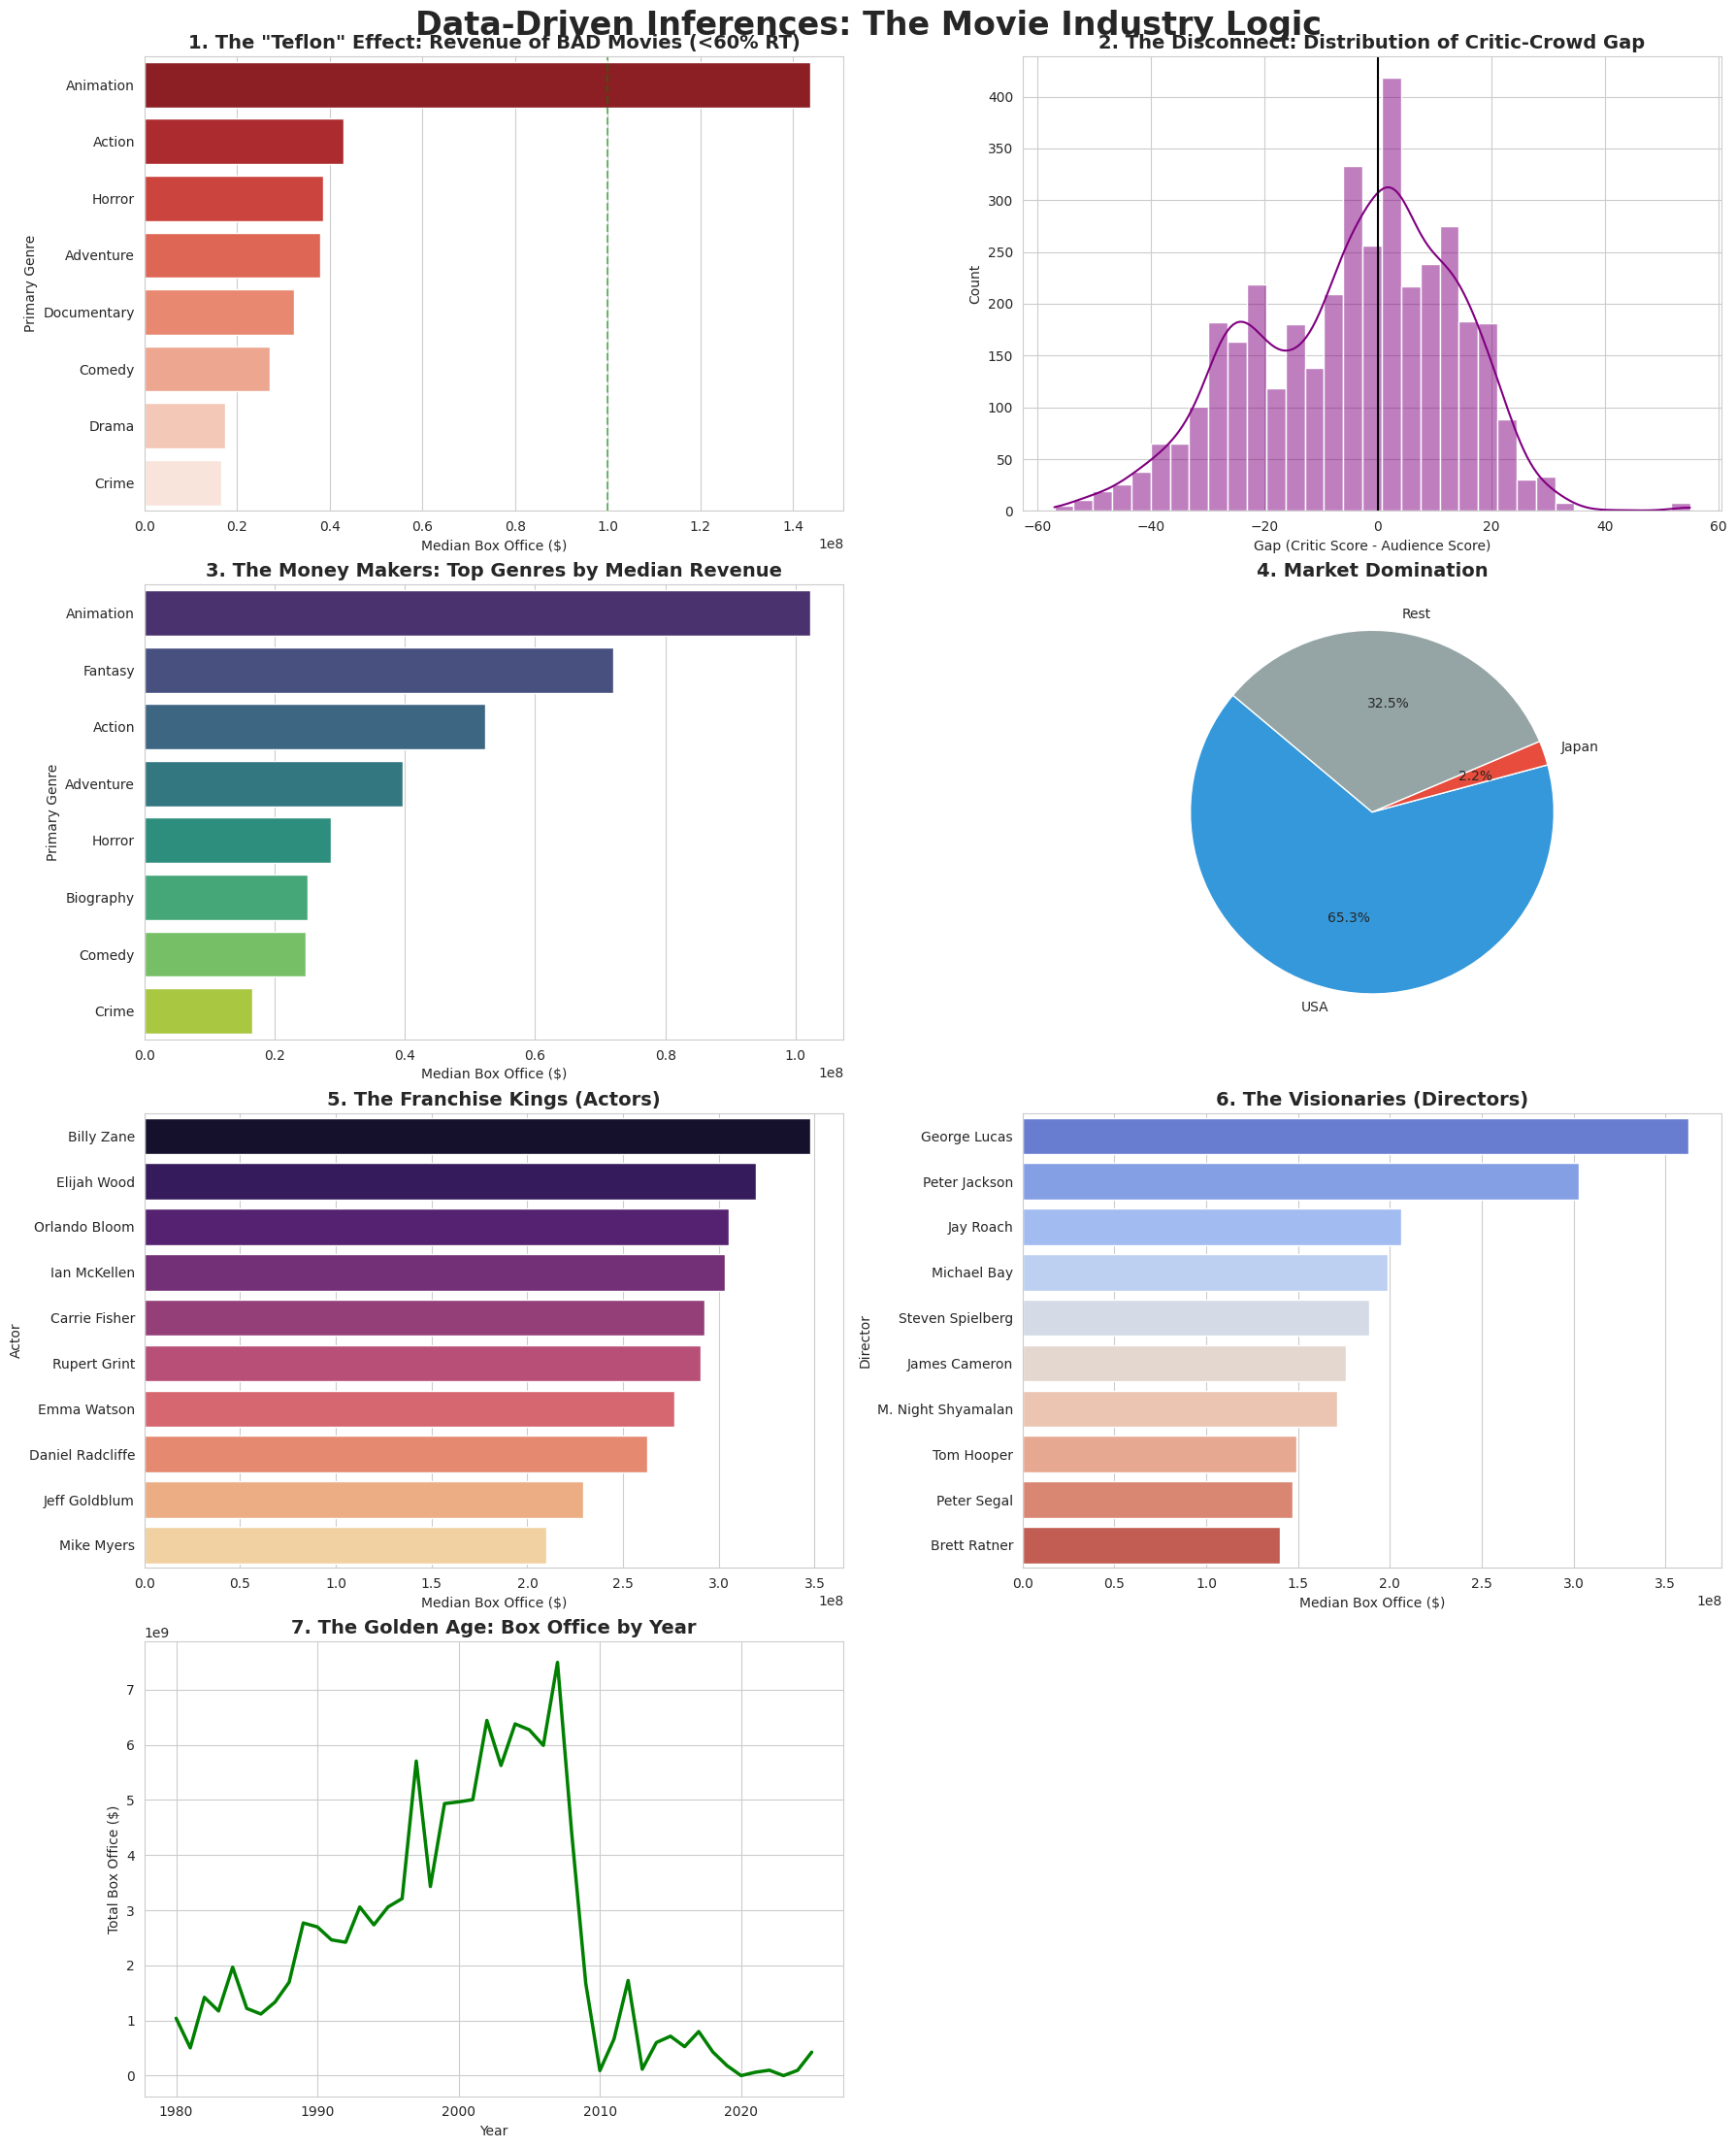

In [18]:


# 1. LOAD THE CLEANED DATA
df = pd.read_csv('movie_data_enriched_cleaned.csv')

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 18)

# Create a subplot grid (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(18, 24))
fig.suptitle('Data-Driven Inferences: The Movie Industry Logic', fontsize=24, fontweight='bold', y=0.92)

# ==========================================
# 1. THE "TEFLON" GENRES (Bad Ratings, Good Money)
# ==========================================
bad_movies = df[df['Rotten_Tomatoes_Imputed'] < 60]
genre_risk = bad_movies.groupby('Primary_Genre')['BoxOffice'].median().sort_values(ascending=False)
valid_genres = bad_movies['Primary_Genre'].value_counts()
genre_risk = genre_risk[valid_genres[valid_genres > 10].index].sort_values(ascending=False).head(8)

sns.barplot(x=genre_risk.values, y=genre_risk.index, palette='Reds_r', ax=axes[0, 0])
axes[0, 0].set_title('1. The "Teflon" Effect: Revenue of BAD Movies (<60% RT)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Median Box Office ($)')
axes[0, 0].set_ylabel('Primary Genre') # Added Y-axis label
axes[0, 0].axvline(100000000, color='green', linestyle='--', alpha=0.5)

# # ==========================================
# # 2. CROWD VS CRITICS (The Gap)
# # ==========================================
sns.histplot(df['Gap_RT'], kde=True, color='purple', ax=axes[0, 1])
axes[0, 1].set_title('2. The Disconnect: Distribution of Critic-Crowd Gap', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Gap (Critic Score - Audience Score)')
axes[0, 1].set_ylabel('Count') # Added Y-axis label
axes[0, 1].axvline(0, color='black', linestyle='-')

# ==========================================
# 3. TOP EARNING GENRES (Overall)
# ==========================================
genre_overall = df.groupby('Primary_Genre')['BoxOffice'].median().sort_values(ascending=False)
counts = df['Primary_Genre'].value_counts()
genre_overall = genre_overall[counts[counts > 20].index].sort_values(ascending=False).head(8)

sns.barplot(x=genre_overall.values, y=genre_overall.index, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('3. The Money Makers: Top Genres by Median Revenue', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Median Box Office ($)') # Added X-axis label
axes[1, 0].set_ylabel('Primary Genre') # Added Y-axis label

# ==========================================
# 4. MARKET DOMINATION (USA vs Japan)
# ==========================================
us_count = df['Country'].str.contains('United States', na=False).sum()
japan_count = df['Country'].str.contains('Japan', na=False).sum()
rest_count = len(df) - us_count - japan_count
axes[1, 1].pie([us_count, japan_count, rest_count], labels=['USA', 'Japan', 'Rest'], colors=['#3498db', '#e74c3c', '#95a5a6'], autopct='%1.1f%%', startangle=140)
axes[1, 1].set_title('4. Market Domination', fontsize=14, fontweight='bold')

# ==========================================
# 5. TOP ACTORS (Consistent Hitmakers)
# ==========================================
actors_exploded = df.assign(Actor=df['Actors'].str.split(', ')).explode('Actor')
actors_exploded = actors_exploded[actors_exploded['Actor'] != 'Unknown']
actor_stats = actors_exploded.groupby('Actor').agg({'BoxOffice': 'median', 'Title': 'count'})
top_actors = actor_stats[actor_stats['Title'] >= 5].sort_values('BoxOffice', ascending=False).head(10)

sns.barplot(x=top_actors['BoxOffice'], y=top_actors.index, palette='magma', ax=axes[2, 0])
axes[2, 0].set_title('5. The Franchise Kings (Actors)', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel('Median Box Office ($)') # Added X-axis label
axes[2, 0].set_ylabel('Actor') # Added Y-axis label

# ==========================================
# 6. TOP DIRECTORS (Consistent Hitmakers)
# ==========================================
director_stats = df.groupby('Director').agg({'BoxOffice': 'median', 'Title': 'count'})
top_directors = director_stats[director_stats['Title'] >= 4].sort_values('BoxOffice', ascending=False).head(10)

sns.barplot(x=top_directors['BoxOffice'], y=top_directors.index, palette='coolwarm', ax=axes[2, 1])
axes[2, 1].set_title('6. The Visionaries (Directors)', fontsize=14, fontweight='bold')
axes[2, 1].set_xlabel('Median Box Office ($)') # Added X-axis label
axes[2, 1].set_ylabel('Director') # Added Y-axis label

# ==========================================
# 7. BOX OFFICE TRENDS (Best Years)
# ==========================================
year_stats = df.groupby('Year')['BoxOffice'].sum()
year_stats = year_stats[year_stats.index >= 1980]

sns.lineplot(x=year_stats.index, y=year_stats.values, color='green', linewidth=2.5, ax=axes[3, 0])
axes[3, 0].set_title('7. The Golden Age: Box Office by Year', fontsize=14, fontweight='bold')
axes[3, 0].set_xlabel('Year') # Added X-axis label
axes[3, 0].set_ylabel('Total Box Office ($)') # Added Y-axis label

axes[3, 1].axis('off') # Hide last plot

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig('Inference_Dashboard.png')
plt.show()

###Checking if any movie earn more than the top oscar winning movies

In [19]:

df = pd.read_csv('movie_data_enriched_cleaned.csv')

# 2. Split Data: Winners vs. Non-Winners
winners = df[df['Oscars_Won'] > 0]
non_winners = df[df['Oscars_Won'] == 0]

# 3. Find the Highest Grossing Oscar Winner
top_winner = winners.sort_values('BoxOffice', ascending=False).iloc[0]
print(f"Highest Grossing Oscar Winner: {top_winner['Title']} (${top_winner['BoxOffice']:,.0f})")

# 4. Check if any Non-Winner earned more
beaters = non_winners[non_winners['BoxOffice'] > top_winner['BoxOffice']]

if len(beaters) > 0:
    print(f"\nYES! {len(beaters)} movies earned more without winning an Oscar:")
    print(beaters[['Title', 'BoxOffice', 'Year']].sort_values('BoxOffice', ascending=False))
else:
    print(f"\nNO. No non-winner earned more than {top_winner['Title']}.")

    # Optional: Show the closest contender
    top_loser = non_winners.sort_values('BoxOffice', ascending=False).iloc[0]
    print(f"But the closest Non-Winner was: {top_loser['Title']} (${top_loser['BoxOffice']:,.0f})")

Highest Grossing Oscar Winner: Titanic ($674,354,882)

NO. No non-winner earned more than Titanic.
But the closest Non-Winner was: Jurassic World ($653,406,625)


Dashboard Updated: Animation is now visible in Charts 2 and 4.


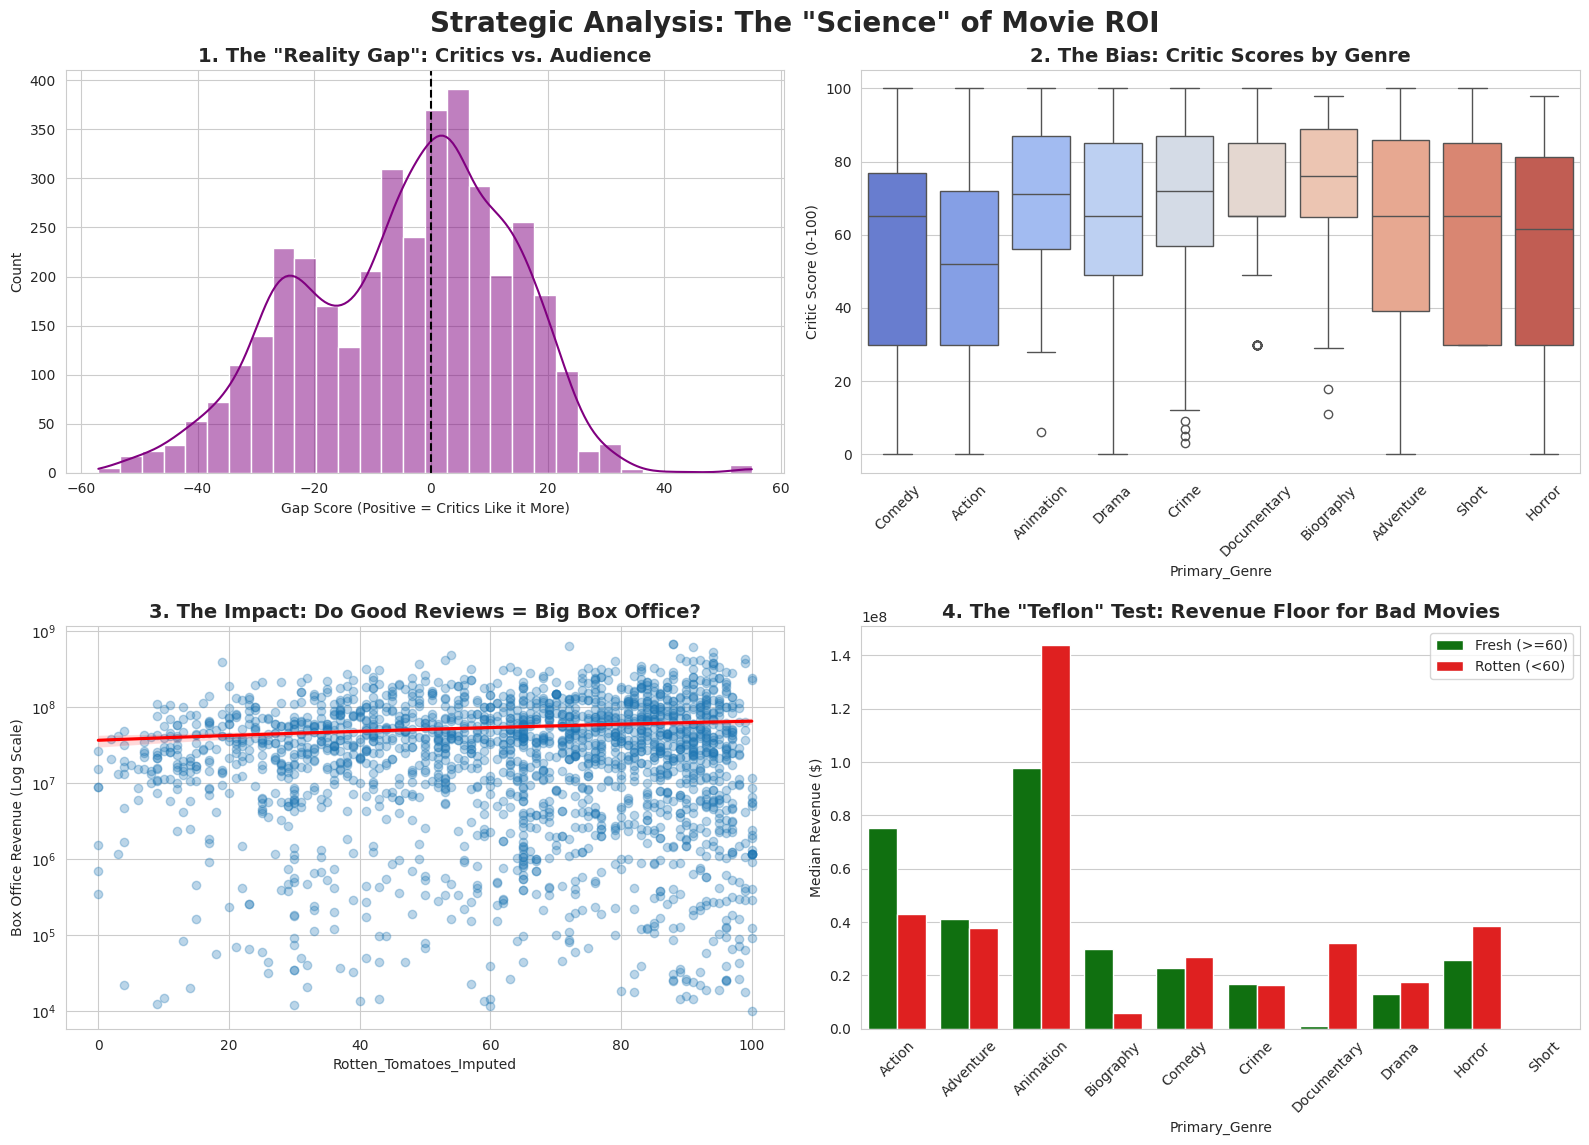


UPDATED INVESTMENT INSIGHTS
1. A 'Bad' Animation movie makes (Median): $143,746,592
2. A 'Bad' Drama makes (Median): $17,381,942
   -> Animation revenue is 8.3x higher than Drama when reviews are bad.


In [21]:

import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# 1. Load the Data
file_path = 'movie_data_enriched_cleaned.csv'
df = pd.read_csv(file_path)

# 2. Feature Engineering
df['Norm_IMDb'] = df['imdbRating'] * 10
df['Gap'] = df['Rotten_Tomatoes_Imputed'] - df['Norm_IMDb']
df['Status'] = df['Rotten_Tomatoes_Imputed'].apply(lambda x: 'Fresh (>=60)' if x >= 60 else 'Rotten (<60)')

# Filter for meaningful Box Office
df_viz = df[df['BoxOffice'] > 10000].copy()

# 3. DEFINE GENRES (The Fix)
# We take Top 10 to ensure 'Animation' (Rank 9) is included
top_genres_index = df['Primary_Genre'].value_counts().nlargest(10).index.tolist()

# Ensure Animation is definitely in the list (just in case)
if 'Animation' not in top_genres_index:
    top_genres_index.append('Animation')

# Filter data to these genres
genre_data = df[df['Primary_Genre'].isin(top_genres_index)]

# 4. SETUP THE DASHBOARD
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Strategic Analysis: The "Science" of Movie ROI', fontsize=20, fontweight='bold', y=0.95)

# --- CHART 1: THE DISCONNECT ---
sns.histplot(df['Gap'], kde=True, ax=axes[0, 0], color='purple', bins=30)
axes[0, 0].set_title('1. The "Reality Gap": Critics vs. Audience', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Gap Score (Positive = Critics Like it More)')
axes[0, 0].axvline(0, color='black', linestyle='--')

# --- CHART 2: GENRE BIAS (Now with Animation!) ---
sns.boxplot(data=genre_data, x='Primary_Genre', y='Rotten_Tomatoes_Imputed', palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('2. The Bias: Critic Scores by Genre', fontsize=14, fontweight='bold')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
axes[0, 1].set_ylabel('Critic Score (0-100)')

# --- CHART 3: IMPACT ANALYSIS ---
sns.regplot(data=df_viz, x='Rotten_Tomatoes_Imputed', y='BoxOffice',
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, ax=axes[1, 0])
axes[1, 0].set_title('3. The Impact: Do Good Reviews = Big Box Office?', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].set_ylabel('Box Office Revenue (Log Scale)')

# --- CHART 4: INVESTMENT STRATEGY (The "Teflon" Test) ---
# Calculate Median Revenue for Fresh vs Rotten per Genre
risk_stats = genre_data.groupby(['Primary_Genre', 'Status'])['BoxOffice'].median().reset_index()

sns.barplot(data=risk_stats, x='Primary_Genre', y='BoxOffice', hue='Status',
            palette={'Fresh (>=60)': 'green', 'Rotten (<60)': 'red'}, ax=axes[1, 1])
axes[1, 1].set_title('4. The "Teflon" Test: Revenue Floor for Bad Movies', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
axes[1, 1].set_ylabel('Median Revenue ($)')
axes[1, 1].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig('Strategic_Inference_Dashboard_Corrected.png')
print("Dashboard Updated: Animation is now visible in Charts 2 and 4.")
plt.show()

# --- PRINT STATS ---
print("\n" + "="*50)
print("UPDATED INVESTMENT INSIGHTS")
print("="*50)

# Check specific values for the story
try:
    bad_anim = risk_stats[(risk_stats['Primary_Genre']=='Animation') & (risk_stats['Status']=='Rotten (<60)')]['BoxOffice'].values[0]
    bad_drama = risk_stats[(risk_stats['Primary_Genre']=='Drama') & (risk_stats['Status']=='Rotten (<60)')]['BoxOffice'].values[0]

    print(f"1. A 'Bad' Animation movie makes (Median): ${bad_anim:,.0f}")
    print(f"2. A 'Bad' Drama makes (Median): ${bad_drama:,.0f}")
    print(f"   -> Animation revenue is {bad_anim/bad_drama:.1f}x higher than Drama when reviews are bad.")
except IndexError:
    print("Not enough data to calculate the exact comparison for printed report (but charts are generated).")

Count of Movies in each Genre and median collection in each
(min 20 entries per genre )


In [22]:
print("Top 10 Primary Genres by Movie Count:")
print(df['Primary_Genre'].value_counts().head(10))

print("\nTop 10 Primary Genres by Median Box Office (all movies, min 20 entries per genre):")
# Replicating logic from Chart 3 to show overall money makers
genre_overall_median = df.groupby('Primary_Genre')['BoxOffice'].median()
counts = df['Primary_Genre'].value_counts()
# Filter for genres with at least 20 movies (to ensure some reliability)
reliable_genres = counts[counts > 20].index
print(genre_overall_median[reliable_genres].sort_values(ascending=False).head(10))

print("\nMedian Box Office for 'Rotten (<60)' Animation movies (if any):")
bad_anim_movies = df[(df['Rotten_Tomatoes_Imputed'] < 60) & (df['Primary_Genre'] == 'Animation')]
if not bad_anim_movies.empty:
    print(bad_anim_movies['BoxOffice'].median())
else:
    print("No 'Rotten (<60)' Animation movies found in the dataset.")

Top 10 Primary Genres by Movie Count:
Primary_Genre
Comedy         956
Drama          862
Action         675
Crime          338
Adventure      230
Documentary    164
Horror         158
Biography      136
Animation       89
Short           51
Name: count, dtype: int64

Top 10 Primary Genres by Median Box Office (all movies, min 20 entries per genre):
Primary_Genre
Animation    102247150.0
Fantasy       71985628.0
Action        52310977.5
Adventure     39675251.0
Horror        28638916.0
Biography     25096862.0
Comedy        24793509.0
Crime         16534221.0
Drama         14789113.0
Thriller       6219181.5
Name: BoxOffice, dtype: float64

Median Box Office for 'Rotten (<60)' Animation movies (if any):
143746592.5


In [23]:
df.describe()

,Year,Oscars_Won,Oscar_Nominations,Total_Wins,Total_Nominations,BoxOffice,imdbRating,Metacritic_Imputed,Rotten_Tomatoes_Imputed,Gap_Metacritic,Gap_RT,Norm_IMDb,Gap
count,3809.000000,3809.000000,3809.000000,3809.000000,3809.000000,2.116000e+03,3809.000000,3809.000000,3809.000000,3809.000000,3809.000000,3809.000000,3809.000000
mean,1989.939879,0.204516,0.448412,5.651090,15.435022,5.468401e+07,6.515516,58.978735,60.658178,-6.176424,-4.496981,65.155159,-4.496981
std,20.236387,0.901924,1.200721,14.350827,34.973895,7.401925e+07,1.104245,15.879398,24.774799,9.540320,17.650495,11.042452,17.650495
min,1896.000000,0.000000,0.000000,0.000000,0.000000,5.090000e+02,1.500000,1.000000,0.000000,-50.000000,-57.000000,15.000000,-57.000000
25%,1980.000000,0.000000,0.000000,0.000000,0.000000,6.279853e+06,5.900000,49.000000,34.000000,-9.000000,-18.000000,59.000000,-18.000000
50%,1997.000000,0.000000,0.000000,1.000000,4.000000,3.118282e+07,6.600000,59.000000,65.000000,-5.000000,-2.000000,66.000000,-2.000000
75%,2005.000000,0.000000,0.000000,5.000000,14.000000,7.035207e+07,7.300000,69.000000,83.000000,-5.000000,9.000000,73.000000,9.000000
max,2025.000000,11.000000,11.000000,215.000000,490.000000,6.743549e+08,10.000000,100.000000,100.000000,24.000000,55.000000,100.000000,55.000000


##Country Domination


In [3]:
N = 8 # Define the number of top countries to display

# Select the top N countries
top_n_countries = country_counts.head(N)

# Calculate the sum of counts for all other countries
other_countries_count = country_counts.iloc[N:].sum()

# Combine the top N countries and the 'Other' category into a new Series
pie_chart_data = pd.concat([
top_n_countries,
pd.Series({'Other': other_countries_count})
])

print(f"Data prepared for pie chart with top {N} countries and 'Other' category:")
print(pie_chart_data)

Data prepared for pie chart with top 8 countries and 'Other' category:
United States     2487
United Kingdom     625
Germany            603
France             457
Canada             208
West Germany       173
Italy              163
Spain               85
Other             1018
dtype: int64


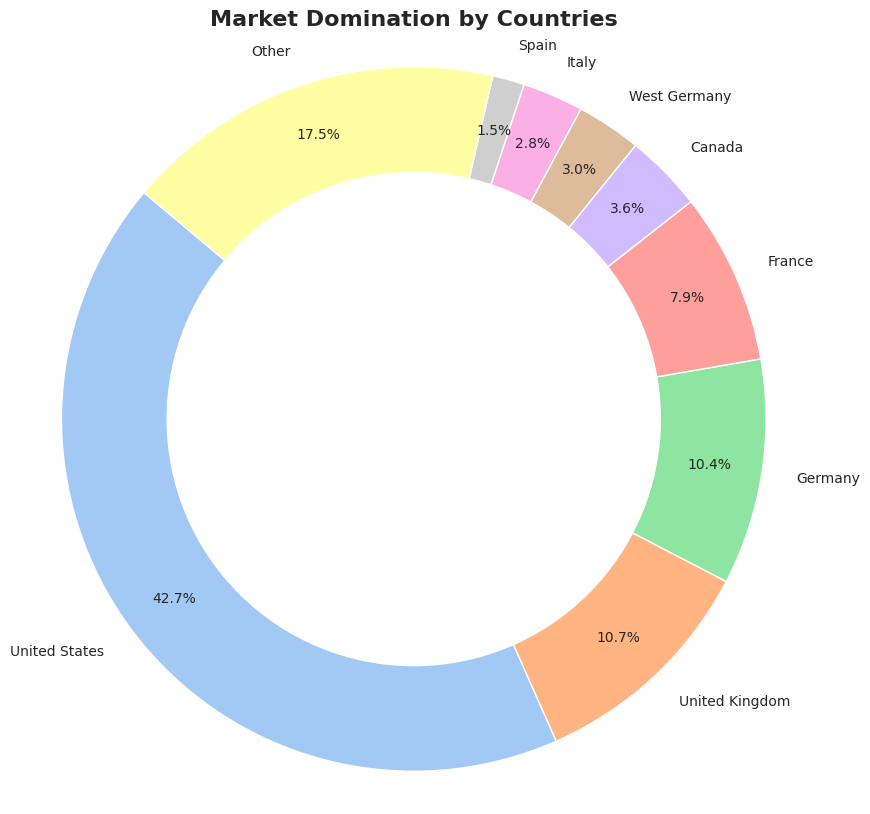

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plot
sns.set_style("whitegrid")

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie(pie_chart_data, labels=pie_chart_data.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85, colors=sns.color_palette('pastel'))

# Draw a circle in the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Market Domination by Countries', fontsize=16, fontweight='bold')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
